In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## define parameters

In [3]:
params = [
    rxmc.params.Parameter("b", float, "[y-units]"),
    rxmc.params.Parameter("m", float, "[no-units]"),
]

## make the model

In [4]:
class LinearModel(rxmc.model.Model):
    def __call__(self, params: OrderedDict):
        return params["m"] * self.x + params["b"]

In [5]:
x = np.linspace(0, 1, 10)

In [6]:
my_model = LinearModel(x)

## define a prior

In [7]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.1),
        ("b", 0.3),
    ]
)

In [8]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [9]:
n_prior_samples = 1000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

In [10]:
y = np.zeros((n_prior_samples, len(my_model.x)))
for i in range(n_prior_samples):
    sample = prior_samples[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, params))

Text(0.5, 1.0, 'prior')

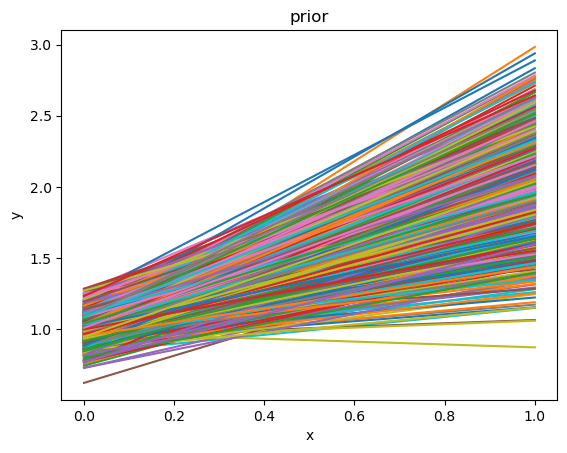

In [11]:
for i in range(n_prior_samples):
    plt.plot(my_model.x, y[i, :])
plt.xlabel("x")
plt.ylabel("y")
plt.title("prior")

Text(0.5, 0.98, 'prior')

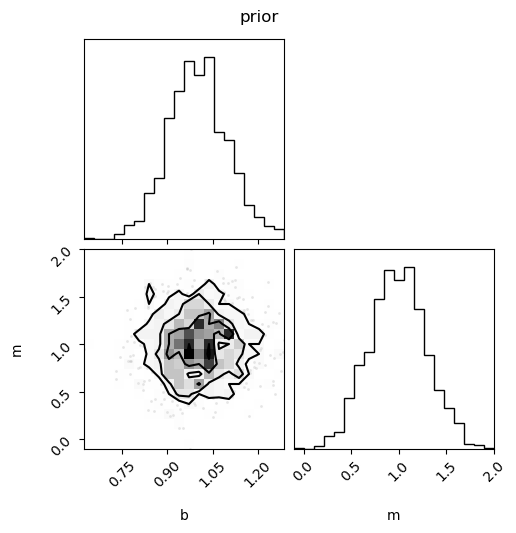

In [12]:
fig = corner.corner(prior_samples, labels=[p.name for p in params])
fig.suptitle("prior")

## find some data
In our case we will synthetically generate some data with noise about a "true" `m` and `b`. Our calibration posterior should converge to be centered about this true point.

Let us assume that the experimentalists made a perfect estimate of the experimental noise in their setup. That is, the error bars they report will correspond exactly to the true distribution from which we sample.

This noise will correspond to statistical noise. Later on we will look at systematic experimental error.

In [13]:
rng = np.random.default_rng(13)

Text(0.5, 1.0, 'experimental constraint')

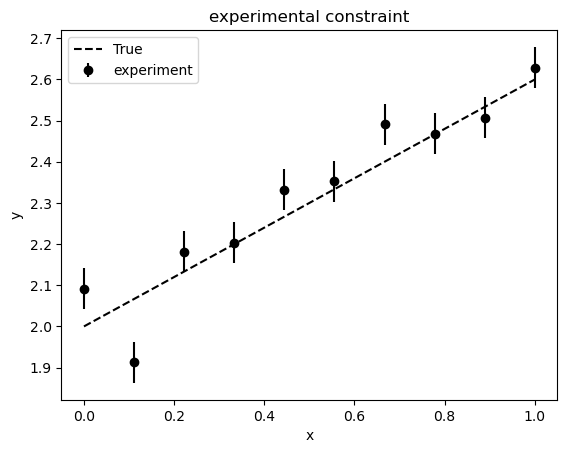

In [14]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

noise = 0.05
y_exp = my_model(true_params) + rng.normal(scale=noise, size=len(my_model.x))
y_exp_err = noise * np.ones_like(y_exp)
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint")

## set up constraint

In [15]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp,
    np.diag(y_exp_err**2),
    my_model,
)

## What is the reduced $\chi^2$ for the prior mean?

In [16]:
constraint.chi2(
    rxmc.params.to_ordered_dict(prior_distribution.mean, params)
) / constraint.n_data_pts

np.float64(274.79425208638565)

In [17]:
constraint.log_det

np.float64(-59.914645471079815)

In [18]:
np.log((noise**2) ** constraint.n_data_pts)

np.float64(-59.914645471079815)

## setting up the calibration

We will run the calibration using the executable `mcmc` provided by `rxmc`

In [19]:
import subprocess

In [20]:
subprocess.run(["which", "mcmc"])

CompletedProcess(args=['which', 'mcmc'], returncode=0)

/home/kyle/mambaforge/envs/om/bin/mcmc


In [21]:
subprocess.run(["mcmc", "--help"])

[kyle-ThinkPad-X390:149494] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31
usage: mcmc [-h] [--nsteps NSTEPS] [--burnin BURNIN] [--batch_size BATCH_SIZE]
            [--output OUTPUT]
            [--proposal_cov_scale_factor PROPOSAL_COV_SCALE_FACTOR]
            [--seed SEED] [--verbose VERBOSE] --corpus_path CORPUS_PATH
            --prior_path PRIOR_PATH

Run MCMC with independent walkers each on their own MPI ranks

options:
  -h, --help            show this help message and exit
  --nsteps NSTEPS       Total number of MCMC steps per chain (including burn-
                        in).
  --burnin BURNIN       Number of steps to not log at the beginning of each
                        chain
  --batch_size BATCH_SIZE
                        Number of steps per batch to incrementally write to
                        file
  --output OUTPUT       Directory to write output to. If it doesn't exist it
                        will be created. All outputs will be wri

CompletedProcess(args=['mcmc', '--help'], returncode=0)

We first need to write our prior and constraint to disk.

In [22]:
import pickle

In [23]:
with open("prior.pkl", "wb") as f:
    pickle.dump(prior_distribution, f)
with open("constraint.pkl", "wb") as f:
    pickle.dump(constraint, f)

## running the calibration

## Handling systematic bias

Text(0.5, 1.0, 'experimental constraint with bias')

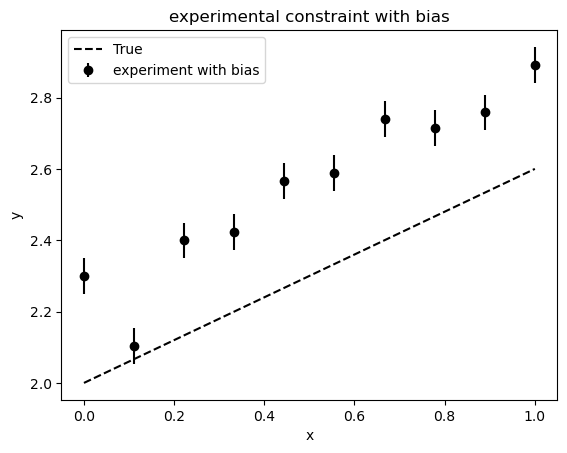

In [30]:
systematic_fractional_err = 0.1
y_exp_with_sys = y_exp * (1.0 + systematic_fractional_err)
plt.errorbar(
    my_model.x,
    y_exp_with_sys,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

In [25]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp_with_sys,
    np.diag(y_exp_err**2) + systematic_fractional_err * np.outer(y_exp, y_exp),
    my_model,
)

In [26]:
x0 = rxmc.params.to_ordered_dict(prior_distribution.mean, params)
constraint.chi2(x0) / constraint.n_data_pts

np.float64(15.553270937608863)

In [27]:
ym = constraint.model(x0)
chi2, log = rxmc.constraint.mahalanobis_distance_cholesky(
    constraint.y, ym, constraint.covariance
)
chi2 / constraint.n_data_pts

np.float64(15.553270937608925)

In [28]:
constraint.log_det

np.float64(-52.23410491733439)

In [29]:
log

np.float64(-52.23410491733431)